<div style="font-family: Arial,sans-serif; color: #3070b3; font-size: 13px; line-height: 14px; margin-top:25px; ">
    <div style="float:right;">
        <a href="https://www.asg.ed.tum.de/en/lmf" title="Home">
            <img src="https://upload.wikimedia.org/wikipedia/commons/c/c8/Logo_of_the_Technical_University_of_Munich.svg" alt="Technical University of Munich" style="height: 42px">
        </a>
    </div>
    <div>
        <ul style="padding: 0pt; margin: 0pt; list-style-type: none;">
            <li> <a href="https://www.asg.ed.tum.de/en/lmf/" title="Home Chair of Remote Sensing Technology" style="text-decoration: none;">Chair of Remote Sensing Technology</a></li>
            <li> <a href="https://www.ed.tum.de/en/" title="Home TUM School of Engineering and Design" style="text-decoration: none;">TUM School of Engineering and Design</a></li>
            <li> <a href="https://www.tum.de/en/" title="Home Technical University of Munich" style="text-decoration: none;"> Technical University of Munich </a></li>
        </ul>
    </div>
</div>

<div style="font-family: Arial,sans-serif; font-size: 14px; line-height: 16px; margin-top:50px">
    <div style="float:right;">
        <span style="font-size:small">Prof. Dr. rer. nat. habil.</span><br />
        <b>Marco Körner</b><br />
    </div>
    <div style="">
        <h1>Machine Learning &mdash; Advanced Methods</h1>
        <p style="font-size:large">Summer Term 2024</p>
    </div>
</div>

---

## 1.2 Ensemble Learning in *scikit-learn*

In this notebook, we execute a simple ensemble learning strategy.
Some of these examples have been adapted from the _scikit-learn_ [example gallery](https://scikit-learn.org/stable/modules/ensemble.html).

In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib import colors

import seaborn as sns
import pandas as pd

import cv2

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from ipywidgets import interact, widgets

##  Histogram-Based Gradient Boosting

### For Classification

In [2]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
print(f'Accuracy after Gradient Boosting: {clf.score(X_test, y_test):.2%}')

Accuracy after Gradient Boosting: 91.30%


### For Regression

In [3]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

X, y = make_friedman1(n_samples=1200, random_state=0, noise=1.0)
X_train, X_test = X[:200], X[200:]
y_train, y_test = y[:200], y[200:]
est = GradientBoostingRegressor(n_estimators=500, 
                                learning_rate=0.1, 
                                max_depth=1, 
                                random_state=0,
                                loss='squared_error').fit(X_train, y_train)

print(f'MSE after Gradient Boosting: {mean_squared_error(y_test, est.predict(X_test)):.2}')

MSE after Gradient Boosting: 3.7


Using our test dataset, we can analyze the _deviance_ of the trained ensemble as a function of the number of boosting iterations. 

In [4]:
test_score = np.zeros(est.n_estimators, dtype=np.float64)
for i, y_pred in enumerate(est.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

plt.plot(np.arange(est.n_estimators) + 1,
         est.train_score_,
         "b-",
         label="Training Set Deviance")
plt.plot(np.arange(est.n_estimators) + 1, 
         test_score, 
         "r-", 
         label="Test Set Deviance")

plt.title("Deviance")
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance");

By repeated permuting the input features, we can also make statements about their particular importance (_mean decrease in impurity, MDI_).

Text(0.5, 1.0, 'Permutation Importance (test set)')

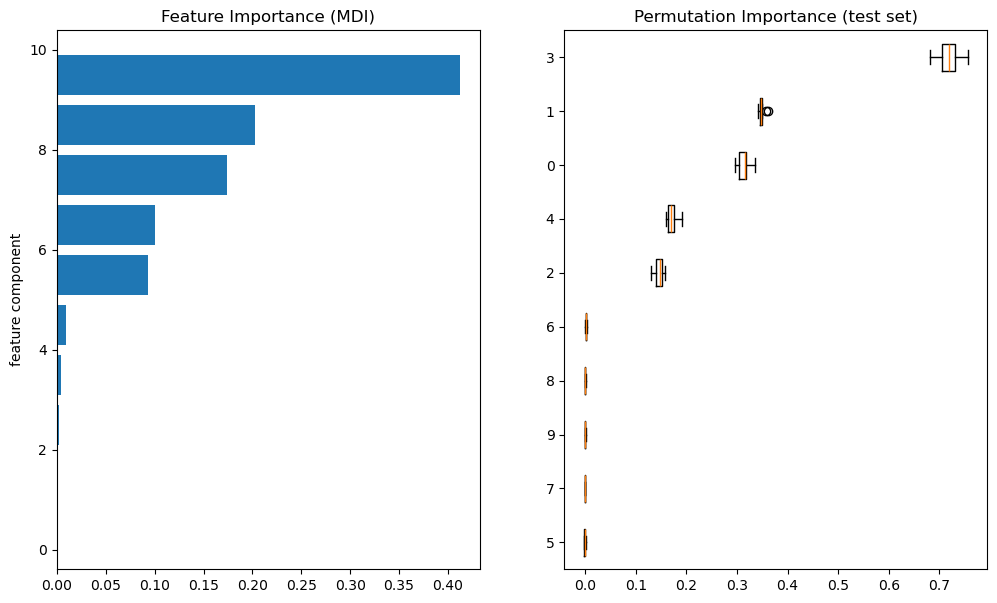

In [5]:
from sklearn.inspection import permutation_importance

feature_importance = est.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

_, axs = plt.subplots(1,2, figsize=(12,7))

axs[0].barh(pos, feature_importance[sorted_idx], align="center")
# plt.yticks(pos, np.array(diabetes.feature_names)[sorted_idx])
axs[0].set_title("Feature Importance (MDI)")
axs[0].set_ylabel('feature component')

result = permutation_importance(est, 
                                X_test, y_test, 
                                n_repeats=10, 
                                random_state=42, 
                                n_jobs=2)
sorted_idx = result.importances_mean.argsort()

axs[1].boxplot(result.importances[sorted_idx].T,
               vert=False,
               labels=np.array([i for i in range(X.shape[1])])[sorted_idx])
axs[1].set_title("Permutation Importance (test set)")

Feature imortance can also be derived for particular samples, e.g., pixels of an image.

The following experiment trains a face detector an reports the most relevant pixel positions of the (aligned and registered) face images.

In [6]:
from sklearn.datasets import fetch_olivetti_faces

data = fetch_olivetti_faces()
X, y = data.data, data.target

mask = y < 5
X = X[mask]
y = y[mask]


from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=750, n_jobs=-1, random_state=42)
forest.fit(X, y)

RandomForestClassifier(n_estimators=750, n_jobs=-1, random_state=42)

Elapsed time to compute the importances: 0.093 seconds


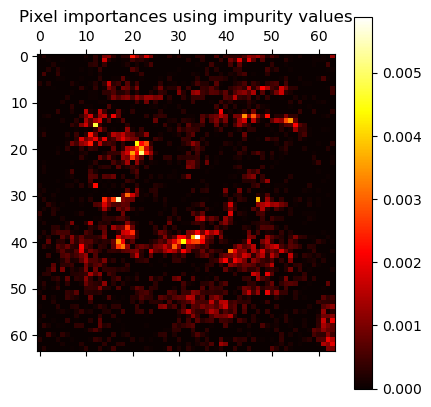

In [7]:
import time

start_time = time.time()
img_shape = data.images[0].shape
importances = forest.feature_importances_
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
imp_reshaped = importances.reshape(img_shape)
plt.matshow(imp_reshaped, cmap=plt.cm.hot)
plt.title("Pixel importances using impurity values")
plt.colorbar();

### Regularizing Ensembles

We've learned that ensemble can still overfit to the training distribution.
To counteract that, the ensemble _hyperparameters_ can be used to _regularize_ the ensemble, _i.e._, to restrict the capacity of the final model.

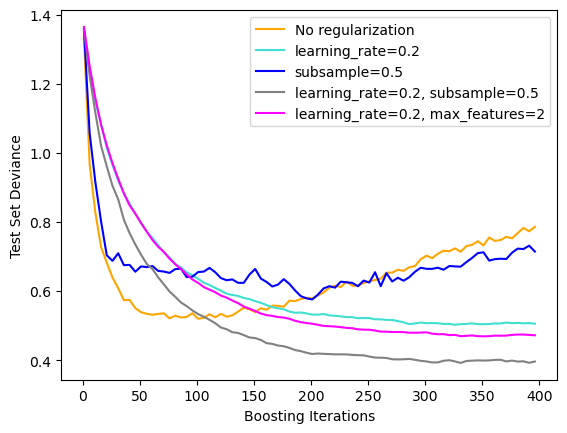

In [8]:
from sklearn import ensemble
from sklearn.metrics import log_loss

X, y = make_hastie_10_2(n_samples=4000, random_state=1)

# map labels from {-1, 1} to {0, 1}
labels, y = np.unique(y, return_inverse=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

original_params = {
    "n_estimators": 400,
    "max_leaf_nodes": 4,
    "max_depth": None,
    "random_state": 2,
    "min_samples_split": 5,
}

plt.figure()

for label, color, setting in [
    ("No regularization", "orange", {"learning_rate": 1.0, "subsample": 1.0}),
    ("learning_rate=0.2", "turquoise", {"learning_rate": 0.2, "subsample": 1.0}),
    ("subsample=0.5", "blue", {"learning_rate": 1.0, "subsample": 0.5}),
    (
        "learning_rate=0.2, subsample=0.5",
        "gray",
        {"learning_rate": 0.2, "subsample": 0.5},
    ),
    (
        "learning_rate=0.2, max_features=2",
        "magenta",
        {"learning_rate": 0.2, "max_features": 2},
    ),
]:
    params = dict(original_params)
    params.update(setting)

    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # compute test set deviance
    test_deviance = np.zeros((params["n_estimators"],), dtype=np.float64)

    for i, y_proba in enumerate(clf.staged_predict_proba(X_test)):
        test_deviance[i] = 2 * log_loss(y_test, y_proba[:, 1])

    plt.plot(
        (np.arange(test_deviance.shape[0]) + 1)[::5],
        test_deviance[::5],
        "-",
        color=color,
        label=label,
    )

plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Test Set Deviance");

# Bagging

In [9]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50  # Number of iterations for computing expectations
n_train = 50  # Size of the training set
n_test = 1000  # Size of the test set
noise = 0.1  # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [
    ("Tree", DecisionTreeRegressor()),
    ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor())),
]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-(x**2)) + 1.5 * np.exp(-((x - 2) ** 2))


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= n_repeat * n_repeat

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print(
        "{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
        " + {3:.4f} (var) + {4:.4f} (noise)".format(
            name, np.mean(y_error), np.mean(y_bias), np.mean(y_var), np.mean(y_noise)
        )
    )

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label=r"$x^\prime \sim y = f(x)+\eta$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\hat{{y}}(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c", label=r"$\mathbb{E}_{x^\prime} \hat{{y}}(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, 0.5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, 0.5))

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


## Voting

In [10]:
from itertools import product
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


estimators={
    'nn':  KNeighborsClassifier(n_neighbors=1),
    'lr':  LogisticRegression(random_state=1), 
    'svm': SVC(kernel='rbf', probability=True),
    'rf':  RandomForestClassifier(random_state=42), 
    'gnb': GaussianNB(),
}
names = {
    'nn': 'Neirest Neighbors', 
    'lr': 'Logistic Regression', 
    'svm': 'SVM (RBF kernel)',
    'rf': 'Random Forest', 
    'gnb': 'Gaussian Naive Bayes',
}

estimators['ensemble'] = VotingClassifier(list(estimators.items()), voting='hard')
names['ensemble'] = 'ensemble'

print('Cross-validation performance statistics (on train set only!):\n')
for label, clf in estimators.items():
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
    print(f"{names[label]} accuracy: {scores.mean():0.2f} (+/- {scores.std():0.2f})")

Cross-validation performance statistics (on train set only!):

Neirest Neighbors accuracy: 0.91 (+/- 0.06)
Logistic Regression accuracy: 0.94 (+/- 0.07)
SVM (RBF kernel) accuracy: 0.95 (+/- 0.05)
Random Forest accuracy: 0.93 (+/- 0.05)
Gaussian Naive Bayes accuracy: 0.89 (+/- 0.07)
ensemble accuracy: 0.94 (+/- 0.05)


Analyzing the individual classifier performances:

In [11]:
_, axarr = plt.subplots(3, 2, sharex="col", sharey="row", figsize=(10, 8))
for ax, (tt, clf) in zip(axarr.ravel(), estimators.items()):
    clf.fit(X,y)
    
    DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.4, ax=ax, response_method="predict")
    
    ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
    ax.set_title(names[tt])

### Hyper-parameter tuning via grid search

In [12]:
clf = VotingClassifier([(name, estimators[name]) for name, clf in estimators.items() if name != 'ensemble'], voting='soft')

params = {
    'nn__n_neighbors': [1,3,5],
    'rf__max_depth': [None,5,10,15],
    'rf__n_estimators': [20, 200],
    'svm__kernel': ('linear', 'rbf'),
}

grid = GridSearchCV(estimator=clf, param_grid=params, cv=5, refit = True, verbose = 2, n_jobs=-1)
grid = grid.fit(X_train, y_train)
print('best hyperparameters after optimization:')
print(grid.best_params_)

predictions = grid.predict(X_train)
print(f'Ensemble reclassification performance on test set:\n{classification_report(y_train, predictions)}') 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
best hyperparameters after optimization:
{'nn__n_neighbors': 5, 'rf__max_depth': None, 'rf__n_estimators': 20, 'svm__kernel': 'linear'}
Ensemble reclassification performance on test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.95      0.92      0.94        39
           2       0.92      0.95      0.94        38

    accuracy                           0.96       112
   macro avg       0.96      0.96      0.96       112
weighted avg       0.96      0.96      0.96       112



We now can evaluate the found classifier on our held-out test dataset:

In [13]:
predictions = grid.predict(X_test)
print(f'Ensemble performance on independent test set:\n{classification_report(y_test, predictions)}') 

Ensemble performance on independent test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.91      0.95        11
           2       0.92      1.00      0.96        12

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38

